## Import the libs

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io

## Import and read the data

In [14]:
data_path = "./data/amazon_data.csv"
data = pd.read_csv(data_path)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
1,2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2,2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
3,2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
4,2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000
...,...,...,...,...,...,...,...
6032,2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
6033,2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
6034,2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700
6035,2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000


In [17]:
close_data = data['Adj Close'].values
close_data

array([  4.46875   ,   4.09687519,   3.48749995, ..., 153.33999634,
       153.38000488, 151.94000244])

## Processing data

In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(close_data.reshape(-1, 1))

### Plotting

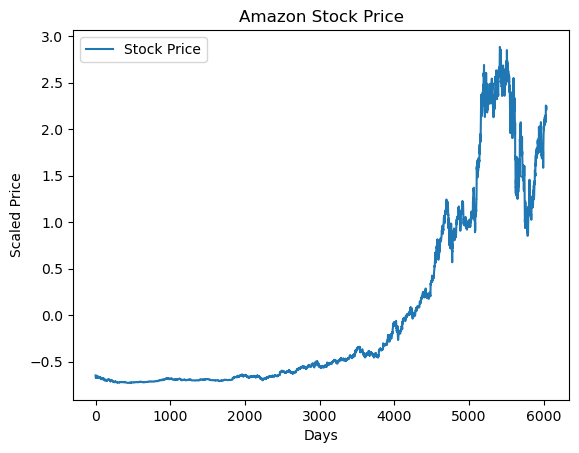

In [25]:
plt.figure(edgecolor='blue')
plt.title('Amazon Stock Price')
plt.xlabel('Days')
plt.ylabel('Scaled Price')
plt.plot(scaled_data, label='Stock Price')
plt.legend()
plt.savefig('./figs/stock_price.png')
plt.show()

